# Buil and train a model using TensorFlow core APIs

In this project we will build and train a Multiple Linear Regression model using TensorFlow Core low_level APIs. The data is Auto MPG whichi is available at the ML repository of UCI. The dataset's size is 398. In this model we will predict fuel efficiency. 

### Steps to follow in this project:
- Load the dataset from https://archive.ics.uci.edu/ml/datasets/auto+mpg , or we can download the data and access to the folder and process the data. 
- Build a multiple Linear Model.
- Evaluate the model.

TensorFlow tutorial: https://www.tensorflow.org/guide/core

In [173]:
#Import libraries for this project
import tensorflow as tf
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt

In [174]:
#Check the tensorflow version in this laptop
print("TensorFlow version: ", tf.__version__)

TensorFlow version:  2.12.0


In [175]:
# Enable GPU for this project: 
devices = tf.config.list_physical_devices()
print("\nDevices: ", devices)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  details = tf.config.experimental.get_device_details(gpus[0])
  print("GPU details: ", details)


Devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU details:  {'device_name': 'METAL'}


## Step 1: Load the dataset and process

This dataset has 8 columns: 'MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration', 'Model Year', 'Origin'. There are missing values in the dataset, so we can either impute the missing values or just delete the missing value rows. So, the steps will be:
- Check for missing values.
- Convert the dataset to tensor.
- Split the data to train/test
- One hot coding for the orgin variable because this is categorical data. 
- Standardize the data, this step is very important for Multiple Linear Regression

In [176]:
#=============================================
#Load the dataset
data_url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
col_names = ['MPG','Cylinders', 'Displacement', 'Horsepower', 'Weight','Acceleration', 'Model Year', 'Origin']

db_car = pd.read_csv(data_url, names=col_names, na_values='?', comment='\t', sep=' ', skipinitialspace=True)

#Now we check for missing values to decide whether we need to impute or not

print(db_car.isna().sum())

print(db_car[db_car.isna().any(axis=1)])

#There are only 6 rows of missing data, we will just remove these rows.
db_car = db_car.dropna()

#Convert the databast to tensor to use tensorflow for training
db_car_tf = tf.convert_to_tensor(db_car, dtype=tf.float32)

# =============================================
#Split the dataset into train and test
#--- One way to split the dataset is to randomly select the indexes for train and test 
'''
#----- Sample size
sample_size = db_car.shape[0]

#----- Shuffle the indices of the samples
index = tf.range(sample_size)
index = tf.random.shuffle(index)

#Find the indices for training and test 
train_size = int(0.8 * sample_size)
index_train = index[:train_size]
index_test = index[train_size:]

#Now we split the data into train and test
db_train, db_test = tf.gather(db_car_tf, index_train), tf.gather(db_car_tf, index_test)

X_train, y_train = db_train[:, 1:], db_train[:, 0]
X_test, y_test = db_test[:, 1:], db_test[:, 0]

'''
 


dataset_shuffled = tf.random.shuffle(db_car_tf, seed=22)
train_data, test_data = dataset_shuffled[100:], dataset_shuffled[:100]
X_train, y_train = train_data[:, 1:], train_data[:, 0]
X_test, y_test = test_data[:, 1:], test_data[:, 0]


#=============================================
#The origin data is categorical, use one dot coding for this column
def onehot_coding_fnt(db):
    #origin column is at the end of the dataset, we need to cast it to tf.int32 for consistency
    og = tf.cast(db[:, -1], tf.int32)
    #Note that one hot coding using the coding number from 0, our data has coding origins from 1. so we need to fix this.
    og_onehot = tf.one_hot(og-1, 3)
    db_onehot = tf.concat([db[:, :-1], og_onehot], axis=1)
    return db_onehot
    
#Using the onehot coding function above to process the x-train and x-test
X_train_onehot, X_test_onehot = onehot_coding_fnt(X_train), onehot_coding_fnt(X_test)
X_train_onehot.numpy()


#=============================================
#Since the data in the dataset follow different ranges, it's important to standardize the data
#We will write functions to standardize the data

class standardize_fnt(tf.Module):
    #since we use the training mean, trainding sd for standardization process for train and test, 
    # we will calculate these value first for this class.
    def __init__(self, db):
        self.mean = tf.math.reduce_mean(db, axis=0)
        self.sd = tf.math.reduce_std(db, axis=0)
        
    def standardize(self, db):
        sdn = (db - self.mean)/self.sd
        return sdn
    
    def un_standardize(self, db):
        un_sdn = db * self.sd + self.mean
        return un_sdn
    
#Using this class to standardize our data
std_x = standardize_fnt(X_train_onehot)
std_y = standardize_fnt(y_train)

X_train_std, y_train_std = std_x.standardize(X_train_onehot), std_y.standardize(y_train)
X_test_std, y_test_std = std_x.standardize(X_test_onehot), std_y.standardize(y_test)     



MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64
      MPG  Cylinders  Displacement  Horsepower  Weight  Acceleration  \
32   25.0          4          98.0         NaN  2046.0          19.0   
126  21.0          6         200.0         NaN  2875.0          17.0   
330  40.9          4          85.0         NaN  1835.0          17.3   
336  23.6          4         140.0         NaN  2905.0          14.3   
354  34.5          4         100.0         NaN  2320.0          15.8   
374  23.0          4         151.0         NaN  3035.0          20.5   

     Model Year  Origin  
32           71       1  
126          74       1  
330          80       2  
336          80       1  
354          81       2  
374          82       1  


## Build a machine learning model
### Multiple Linear Regression

Using TensorFlow Core APIs to build the model. Note that the Linear Regression model is as following. TensorFlow graph `@tf.function` is used to help saving and loading model after training. 

$${\mathrm{Y}} = {\mathrm{X}}w + \epsilon$$

where

* $\underset{m\times 1}{\mathrm{Y}}$: target vector
* $\underset{m\times n}{\mathrm{X}}$: feature matrix
* $\underset{n\times 1}w$: weight vector
* $\epsilon$: bias

#### Step 1: Define the Linear Regression class:
- In this class, we will initiate the parameters value at the first iteration.
- Using these values to calculate the predicted y_hat value.

#### Step 2: Define the Loss function.

The loss function  is used to evaluate the model's performance during the training process.

The the mean squared error (MSE) is an ideal choice for the loss function of continous data. The MSE is defined by the following equation:

$$MSE = \frac{1}{m}\sum_{i=1}^{m}(\hat{y}_i -y_i)^2$$

where

* $\hat{y}$: vector of predictions
* $y$: vector of true targets

#### Step 3: Using Gradient Descent method to find the optimal parameters $w$ and $\epsilon$ by minimize the loss function.
First, we write a training loop to update the model's parameters using MSE loss function and its gradient wrt the parameters.
At each step, the parameters are updated by taking a step in the opposite direction of the gradients. Using a learning rate to update the parameters. 

Next, write a training loop to iteratively update your model's parameters by making use of the MSE loss function and its gradients with respect to the input parameters.








In [178]:
# To train a ML using TensorFlow, we need to randomly choose the initiative values for the parameters at the first iteration. 
# After that using the Linear Regression formula to calculate the y_hat.

class LinearRegression(tf.Module):
    def __init__(self):
      self.first = True
      
    @tf.function
    def __call__(self, db):
      if self.first:
        w_random = tf.random.uniform(shape=[db.shape[-1], 1]) # w_random has the dimension is (#columns in db x 1)
        e_random = tf.random.uniform(shape=[]) # e_random is just a scalar
        
        self.w = tf.Variable(w_random)
        self.e = tf.Variable(e_random)
        
        self.first = False
      y_hat = tf.add(tf.matmul(db, self.w), self.e)
      return tf.squeeze(y_hat, axis=1)
        
# Define the Loss function
def mse_loss_fnt(y_hat, y):
  mse = tf.reduce_mean(tf.square(y_hat -y))
  return mse
  

In [179]:
lin_reg = LinearRegression()
prediction = lin_reg(X_train_std[:1])
prediction_unnorm = std_y.un_standardize(prediction)
prediction_unnorm.numpy()

2024-04-15 14:57:19.234356: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 14:57:19.248424: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


array([11.909517], dtype=float32)


#### Step 3: Train and evaluate your model

Remember among all the method for training, it's sufficient to use mini-batches. This is beneficial for memory efficiency and also faster convergence. 

Using mini-batches for training provides both memory efficiency and faster convergence. The `tf.data.Dataset` API has useful functions for batching and shuffling. The API enables you to build complex input pipelines from simple, reusable pieces. Learn more about building TensorFlow input pipelines in [this guide](https://www.tensorflow.org/guide/data).

Next, write a training loop to iteratively update your model's parameters by making use of the MSE loss function and its gradients with respect to the input parameters.

This iterative method is referred to as [gradient descent](https://developers.google.com/machine-learning/glossary#gradient-descent){:.external}. At each iteration, the model's parameters are updated by taking a step in the opposite direction of their computed gradients. The size of this step is determined by the learning rate, which is a configurable hyperparameter. Recall that the gradient of a function indicates the direction of its steepest ascent; therefore, taking a step in the opposite direction indicates the direction of steepest descent, which ultimately helps to minimize the MSE loss function.

In [180]:
#================================================
#Using tf.data.Dataset 
#Slicing data into smaller batches, also suffle each time to increase the randomness. This also help with convergence.
batch_size = 64

#Create training dataset
X_train_final = tf.data.Dataset.from_tensor_slices((X_train_std, y_train_std))
X_train_final = X_train_final.shuffle(buffer_size=X_train.shape[0]).batch(batch_size)

X_test_final = tf.data.Dataset.from_tensor_slices((X_test_std, y_test_std))
X_test_final = X_test_final.shuffle(buffer_size=X_test.shape[0]).batch(batch_size)



Now the data set is ready, we will build a loop to train the model in order to minimize the loss function.

In this step, we will use the tf.GradientTape. In TensorFlow, tf.GradientTape is a context manager that records operations for automatic differentiation. It allows you to compute gradients of a computation with respect to some inputs, typically model variables, by keeping track of the operations performed on tensors inside the context.


Sample code for tf.GradientTape
###### Define some variables
x = tf.Variable(3.0)
y = tf.Variable(4.0)

###### Record operations inside a GradientTape context
with tf.GradientTape() as tape:
    z = x**2 + y**3

###### Compute gradients of z with respect to x and y
grads = tape.gradient(z, [x, y])

print("Gradient of z with respect to x:", grads[0].numpy())  # Output: 6.0
print("Gradient of z with respect to y:", grads[1].numpy())  # Output: 48.0


In [181]:
# First, we need to set up the hyper parameters. each epoch is one time that all data was processed.

epochs = 100
learning_rate = 0.01

#We save these for the plot later
train_losses, test_losses = [], [] 

tf.random.set_seed(42)

#The training loop

for epoch in range(epochs):
    batch_losses_train, batch_losses_test = [], []
    
    # -------Iterate through batches of training data------
    for x_batch, y_batch in X_train_final:
        #GradientTape is used for automatic differentiation
        with tf.GradientTape() as tape:
            # Make prediction for the current batch
            y_pred_batch = lin_reg(x_batch)
            
            # Compute the mean squared error loss for the batch
            batch_loss = mse_loss_fnt(y_pred_batch, y_batch)
            
        #Calculate gradients of the loss wrt the pamameters: w, e
        grads = tape.gradient(batch_loss, lin_reg.variables)
        
        #Update the model parameters using the gradient descent
        for gradient, variable in zip(grads, lin_reg.variables):
            #Update each variable by subtracting the product of learning rate and gradient 
            variable.assign_sub(learning_rate  * gradient)
        
        # Track the batch_level training loss for monitoring
        batch_losses_train.append(batch_loss)
        
    #---------- Iterate through the testing data ---------
    
    # Iterate through batches of testing data
    for x_batch, y_batch in X_test_final:
        # Make predictions for the current batch
        y_pred_batch = lin_reg(x_batch)
        
        # Compute the mean squared error loss for the batch
        batch_loss = mse_loss_fnt(y_pred_batch, y_batch)
        
        # Track the batch-level testing performance by appending the loss
        batch_losses_test.append(batch_loss)

    # Calculate the average of training loss \ testing loss over all batches
    average_train_loss = tf.reduce_mean(batch_losses_train)
    average_test_loss = tf.reduce_mean(batch_losses_test)

    # Track the epoch-level model performance by appending the average testing loss
    train_losses.append(average_train_loss)
    test_losses.append(average_test_loss)

    # Print the mean squared error for training data every 10 epochs
    if epoch % 10 == 0:
        print(f'Mean squared error for step {epoch}: {average_test_loss.numpy():0.9f}')

    # Output final losses
    print(f"\nFinal train loss: {train_loss:0.9f}")
    print(f"Final test loss: {test_loss:0.9f}")

        
    



2024-04-15 14:57:27.857592: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [292]
	 [[{{node Placeholder/_1}}]]
2024-04-15 14:57:27.869236: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 14:57:27.904362: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 14:57:27.941463: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 14:57:27.972795: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-15 14:57:27.983062: I tensorfl

Mean squared error for step 0: 3.202020407

Final train loss: 0.387787074
Final test loss: 0.584995210

Final train loss: 0.387787074
Final test loss: 0.584995210

Final train loss: 0.387787074
Final test loss: 0.584995210

Final train loss: 0.387787074
Final test loss: 0.584995210

Final train loss: 0.387787074
Final test loss: 0.584995210

Final train loss: 0.387787074
Final test loss: 0.584995210

Final train loss: 0.387787074
Final test loss: 0.584995210

Final train loss: 0.387787074
Final test loss: 0.584995210

Final train loss: 0.387787074
Final test loss: 0.584995210

Final train loss: 0.387787074
Final test loss: 0.584995210
Mean squared error for step 10: 0.685690165

Final train loss: 0.387787074
Final test loss: 0.584995210

Final train loss: 0.387787074
Final test loss: 0.584995210

Final train loss: 0.387787074
Final test loss: 0.584995210

Final train loss: 0.387787074
Final test loss: 0.584995210

Final train loss: 0.387787074
Final test loss: 0.584995210

Final train 

In [199]:
# Access the trained parameters of the lin_reg model
trained_parameters = lin_reg.trainable_variables

# Print the trained parameters
for param in trained_parameters:
    print(param)

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.0014340988>
<tf.Variable 'Variable:0' shape=(9, 1) dtype=float32, numpy=
array([[-0.05433556],
       [ 0.15875687],
       [-0.05706667],
       [-0.6589987 ],
       [ 0.03631757],
       [ 0.3589948 ],
       [ 0.47271934],
       [ 0.48207235],
       [ 0.5335209 ]], dtype=float32)>


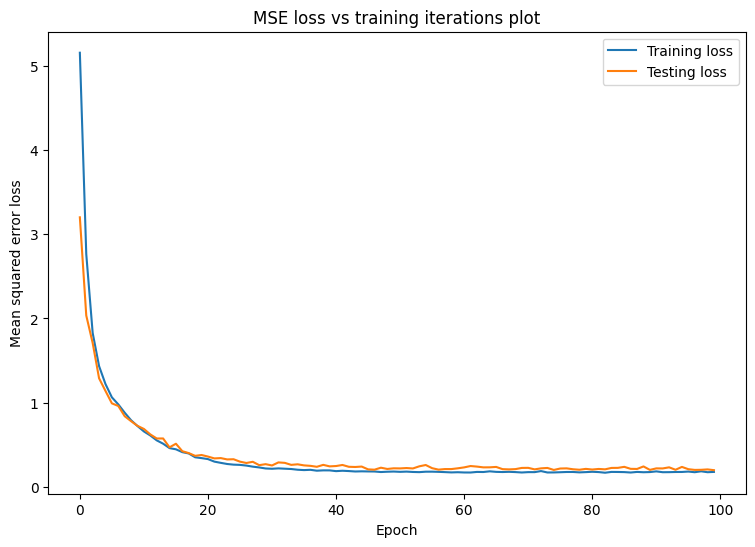

In [184]:
matplotlib.rcParams['figure.figsize'] = [9, 6]

plt.plot(range(epochs), train_losses, label = "Training loss")
plt.plot(range(epochs), test_losses, label = "Testing loss")
#plt.ylim(0,3)
plt.xlabel("Epoch")
plt.ylabel("Mean squared error loss")
plt.legend()
plt.title("MSE loss vs training iterations plot");

## Save and load the model
Start by making an export module that takes in raw data and performs the following operations:
- Feature extraction 
- Standardization
- Prediction
- Unstandardization

In [196]:
class ExportModule(tf.Module):
    def __init__(self, model, extract_features, std_x, std_y):
        # Initialize the model and preprocessing functions
        self.model = model
        self.extract_features = extract_features
        self.std_x = std_x
        self.std_y = std_y

    @tf.function(input_signature=[tf.TensorSpec(shape=[None, None], dtype=tf.float32)])
    def __call__(self, x):
        # Preprocess the input data
        x = self.extract_features(x)  # Extract features from input data
        x = self.std_x.standardize(x)  # Standardize (normalize) input data
        # Make predictions using the model
        y = self.model(x)
        # Postprocess the predictions
        y = self.std_y.un_standardize(y)  # Unstandardize (denormalize) output predictions
        return y


In [200]:
lin_reg_export = ExportModule(model=lin_reg,
                              extract_features=onehot_coding_fnt,
                              std_x=std_x,
                              std_y=std_y)

#### Model deployment

If you want to save the model at its current state, use the `tf.saved_model.save` function. 


To load a saved model for making predictions, use the `tf.saved_model.load` function.

In [203]:
import tempfile
import os

models = tempfile.mkdtemp()
save_path = os.path.join(models, 'lin_reg_export')
tf.saved_model.save(lin_reg_export, save_path)

INFO:tensorflow:Assets written to: /var/folders/3t/rwcn0jt95hj3mylt31sbtsm00000gv/T/tmphn0wnz7k/lin_reg_export/assets


In [205]:
lin_reg_loaded = tf.saved_model.load(save_path)
test_preds = lin_reg_loaded(X_test)
test_preds[:10].numpy()

2024-04-15 16:45:57.985520: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


array([28.85603  , 32.94698  , 28.337957 , 33.8785   , 23.166735 ,
       11.9220705, 29.273777 , 26.833492 , 20.05007  , 23.073439 ],
      dtype=float32)